In [1]:
import pandas as pd

In [2]:
housing=pd.read_csv("C:\\Users\\rohit.a\\Downloads\\housing\\housing.csv")

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [5]:
import numpy as np
housing["income_cat"]=np.ceil(housing["median_income"]/1.5)

In [6]:
housing["income_cat"].where(housing["income_cat"]<5,5.0,inplace=True)

In [7]:
housing.hist(bins=50,figsize=(20,15))
import matplotlib.pyplot as plt
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(housing, test_size=0.2, random_state=42)

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
s= StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in s.split(housing, housing['income_cat']):
    strat_train_set=housing.loc[train_index]
    strat_test_set=housing.loc[test_index]


In [10]:
strat_train_set.shape

(16512, 11)

In [11]:
strat_test_set.shape

(4128, 11)

In [12]:
housing["income_cat"].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [13]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [14]:
test["income_cat"].value_counts()/len(test)

3.0    0.358527
2.0    0.324370
4.0    0.167393
5.0    0.109496
1.0    0.040213
Name: income_cat, dtype: float64

# Data Cleaning

In [15]:
housing=strat_train_set.drop("median_house_value",axis=1)

In [16]:
housing_labels= strat_train_set["median_house_value"].copy()

In [17]:
housing.isna().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
ocean_proximity       False
income_cat            False
dtype: bool

## Create Machine Learning Pipeline
Imputer will replace nan fields with median values of the corresponding columns, Standard Scaler will perform standardization ie; it will subtract values with mean and divide by variance

In [18]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.pipeline import Pipeline

In [55]:
from sklearn.base import TransformerMixin, BaseEstimator
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names=attribute_names
    def fit(self, X,y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names].values
    

In [57]:
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)
    
housing_num=housing.drop("ocean_proximity",axis=1)
num_attributes=list(housing_num)
cat_attributes=['ocean_proximity']

MLPipeline1=Pipeline([('selector',DataFrameSelector(num_attributes)),
              ("imputer",Imputer(strategy="median")),
              ("std_scalar",StandardScaler()),
            ])
MLPipeline2=Pipeline([('selector',DataFrameSelector(cat_attributes)),
                     ('label_binarizer',MyLabelBinarizer()),
                     ])

In [60]:
from sklearn.pipeline import FeatureUnion
full_pipeline= FeatureUnion(transformer_list=[('pipeline1',MLPipeline1),('pipeline2',MLPipeline2),])
housing_prepared=full_pipeline.fit_transform(housing)

In [61]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [62]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

DT= DecisionTreeRegressor()
RF= RandomForestRegressor()

In [63]:
DT_cv=cross_val_score(DT,housing_prepared,housing_labels,scoring='neg_mean_squared_error',cv=10)

In [67]:
RF_cv=cross_val_score(RF,housing_prepared,housing_labels,scoring='neg_mean_squared_error',cv=10)

In [69]:
DT_rmse=np.sqrt(-DT_cv)

In [70]:
RF_rmse=np.sqrt(-RF_cv)

In [74]:
def display_scores(score):
    print("Score: ",score)
    print("Mean: ",score.mean())
    print("Standard Deviation: ",score.std())

In [75]:
display_scores(DT_rmse)
display_scores(RF_rmse)

Score:  [68117.5877806  66174.93864022 72403.5576604  69889.26346953
 68139.21925299 75254.27842563 67667.94157541 69102.37626428
 70787.14929924 69447.02259262]
Mean:  69698.33349609213
Standard Deviation:  2475.751502909798
Score:  [49565.37997492 48150.44796004 51973.2507273  53197.33307033
 51979.9774515  55690.35982362 52734.55959823 52176.8208999
 54595.31751649 50965.97273497]
Mean:  52102.94197572941
Standard Deviation:  2099.27755279195


In [76]:
from sklearn.model_selection import GridSearchCV

In [80]:
parameters={'n_estimators':[10,20,30],
            'max_features':['auto','sqrt','log2'],
           }
model=RandomForestRegressor()

In [84]:
grid_search=GridSearchCV(model,parameters,cv=5,scoring='neg_mean_squared_error',refit='True')

In [85]:
grid_search.fit(housing_prepared,housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 20, 30], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit='True', return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [86]:
model2=grid_search.best_estimator_

Testing the model using test dataset

In [87]:
test_data= strat_test_set.drop("median_house_value", axis=1)

In [88]:
test_labels=strat_test_set["median_house_value"].copy()

In [89]:
test_prepared= full_pipeline.transform(test_data)

In [90]:
prediction= model2.predict(test_prepared)

In [92]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(test_labels, prediction)

In [93]:
rmse=np.sqrt(mse)

In [94]:
print ("Root Mean Squared Error: ",rmse)

Root Mean Squared Error:  47871.480750539245


# Spam Classifier 

In [145]:
import pandas as pd
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.base import BaseEstimator, TransformerMixin

In [146]:
df= pd.read_csv("C:\\Users\\rohit.a\\Downloads\\spam_sms\\spam.csv", encoding='ISO-8859-1')

In [147]:
cols=['Unnamed: 2','Unnamed: 3','Unnamed: 4']
df.drop(cols,axis=1,inplace=True)

In [148]:
df.rename(columns={'v1': 'Label', 'v2': 'Message'}, inplace=True)

In [149]:
df.shape

(5572, 2)

#### Create Custom Transformer for selecting columns from Pandas dataframe and a transformer for encoding labels

In [150]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name=attribute_name
    def fit(self,X,y=None):
        return self
    def transform(self, X):
        print (X[self.attribute_name].values)
        return X[self.attribute_name].values
    
class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

#### Create Custom Transformer for cleaning data

In [151]:
class NLTK_Preprocessing_Module(BaseEstimator, TransformerMixin):
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        return (self.helperFunction(X))
    
    def lemmatize_all(self,sentence):
        
        wnl = WordNetLemmatizer()
        for word, tag in pos_tag(word_tokenize(sentence)):
            if tag.startswith("NN"):
                yield wnl.lemmatize(word, pos='n')
            elif tag.startswith('VB'):
                yield wnl.lemmatize(word, pos='v')
            elif tag.startswith('JJ'):
                yield wnl.lemmatize(word, pos='a')
            elif tag.startswith('R'):
                yield wnl.lemmatize(word, pos='r')
            else:
                yield word
            
    def msgProcessing(self,raw_msg):
        
        meaningful_words=[]
        words2=[]
        raw_msg = str(raw_msg.lower())
        raw_msg=re.sub(r'[^a-z\s]', ' ', raw_msg)
        words=raw_msg.split()
        """Remove words with length lesser than 2"""
        for i in words:
            if len(i)>=2:
                words2.append(i)
        stops=set(stopwords.words('english'))
        meaningful_words=" ".join([w for w in words2 if not w in stops])
        return(" ".join(self.lemmatize_all(meaningful_words)))


    def helperFunction(self,df):
        
        print ("Data Preprocessing!!!")
        cols=['Message']
        df=df[cols]
        df.Message.replace({r'[^\x00-\x7F]+':''},regex=True,inplace=True)
        num_msg=df[cols].size
        clean_msg=[]
        for i in range(0,num_msg):
            clean_msg.append(self.msgProcessing(df['Message'][i]))
        df['Processed_msg']=clean_msg
        X=df['Processed_msg']
        print ("Data Preprocessing Ends!!!")
        return X

In [152]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelBinarizer
label=["Label"]
pipeline1=Pipeline([("nltk",NLTK_Preprocessing_Module()),])

pipeline2=Pipeline([("dataframe_selector",DataFrameSelector(label)),
                    ("label binarizer",MyLabelBinarizer()),])


In [153]:
data_prepared=pipeline1.fit_transform(df)

Data Preprocessing!!!


C:\Users\rohit.a\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Data Preprocessing Ends!!!


In [154]:
encoded_label=pipeline2.fit_transform(df)

[['ham']
 ['ham']
 ['spam']
 ...
 ['ham']
 ['ham']
 ['ham']]


In [155]:
from sklearn.model_selection import train_test_split
xtrain,xval,ytrain,yval= train_test_split(data_prepared,encoded_label,test_size=0.2, random_state=42)


#### Convert text data to vectors using CountVectorizer

In [177]:
from sklearn.feature_extraction.text import CountVectorizer

def vectorizer(train,test):
    vectorizer= CountVectorizer(analyzer="word", tokenizer= None, preprocessor= None, stop_words= None, max_features=6000)
    train_data_features= vectorizer.fit_transform(train)
    train_data_features= train_data_features.toarray()
    test_data_features=vectorizer.transform(test)
    test_data_features=test_data_features.toarray()
    return train_data_features,test_data_features

In [178]:
xtrain_vector,xval_vector=vectorizer(xtrain,xval)

## Training various classifiers
#### 1. Naive Bayes
#### 2. Decision Tree
#### 3. Random Forest
#### 4. Support Vector Machine

Train various classifiers using default hyperparameters and check how well they perform using k-cross validation.

In [187]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_predict

In [188]:
MNB=MultinomialNB()
DT=DecisionTreeClassifier()
RF=RandomForestClassifier()
SVM=svm.SVC()

In [189]:
MNB_scores=cross_val_predict(MNB, xtrain_vector, ytrain,cv=5,method="predict_proba")
DT_scores=cross_val_predict(DT, xtrain_vector, ytrain,cv=5,method="predict_proba")
RF_scores=cross_val_predict(RF, xtrain_vector, ytrain,cv=5,method="predict_proba")
SVM_scores=cross_val_predict(SVM, xtrain_vector, ytrain,cv=5,method="decision_function")

C:\Users\rohit.a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rohit.a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rohit.a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\rohit.a\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversio

In [195]:
MNB_scores1=MNB_scores[:,1]
DT_scores1=DT_scores[:,1]
RF_scores1=RF_scores[:,1]
SVM_scores1=SVM_scores

## Plot Receiver Output Characteristic(ROC) Curve
Calculate FPR(False Positive Rate) and TPR(True Positive Rate) for generating the ROC Curve.

In [197]:
from sklearn.metrics import roc_curve
fpr_MNB,tpr_MNB,threshold_MNB=roc_curve(ytrain, MNB_scores1)
fpr_DT,tpr_DT,threshold_DT=roc_curve(ytrain, DT_scores1)
fpr_RF,tpr_RF,threshold_RF=roc_curve(ytrain, RF_scores1)
fpr_SVM,tpr_SVM,threshold_SVM=roc_curve(ytrain, SVM_scores1)

In [206]:
import matplotlib.pyplot as plt
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Label')
    plt.legend(loc="lower right")
    

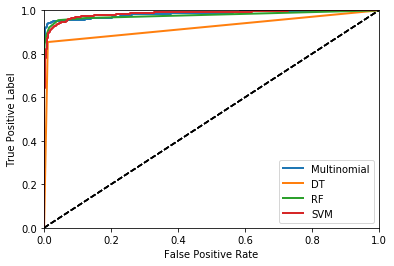

In [208]:
plot_roc_curve(fpr_MNB,tpr_MNB,"Multinomial")
plot_roc_curve(fpr_DT,tpr_DT,"DT")
plot_roc_curve(fpr_RF,tpr_RF,"RF")
plot_roc_curve(fpr_SVM,tpr_SVM,"SVM")

There is a tradeoff between TPR and FPR. Higher the TPR, higher will be the FPR. A good classifier will stay as far away from the dotted lines, ie to the top left corner. To check which classifier performs better, calculate the Area Under Curve score. A good classifier wil have ROC AUC score 1. 

In [214]:
from sklearn.metrics import roc_auc_score
auc_MNB=roc_auc_score(ytrain, MNB_scores1)
auc_DT=roc_auc_score(ytrain, DT_scores1)
auc_RF=roc_auc_score(ytrain, RF_scores1)
auc_SVM=roc_auc_score(ytrain, SVM_scores1)

In [215]:
print ("ROC-AUC Score of Multinomial NB: ",auc_MNB)
print ("ROC-AUC Score of Decision Tree: ",auc_DT)
print ("ROC-AUC Score of Random Forest: ",auc_RF)
print ("ROC-AUC Score of Support Vector Machine: ",auc_SVM)

ROC-AUC Score of Multinomial NB:  0.9841830048341882
ROC-AUC Score of Decision Tree:  0.9215657302054312
ROC-AUC Score of Random Forest:  0.9777779224273353
ROC-AUC Score of Support Vector Machine:  0.9855338870518395


The ROC AUC score of SVM is clearly the largest, hence SVM is the best performing model followed by Decision Tree. We will optimize the hyperparameters of SVM using GridSearch. GridSearchCV is a built-in function in sklearn which allows us to find the optimal parameters of a model. 

## Hyperparameter Optimization  